## Demo of how the risk factors are generated. Hyperparameters are not necessarily reasonable. For the number of risk factors, we set K=3. And for the number of bonds, we set m=10.

In [4]:
from bond_portfolio_gen import *
from MFM_constructor import *
from utils import seed_all
from scipy.stats import ortho_group
import numpy as np
import matplotlib.pyplot as plt


seed_all(1234)

K = 3
m = 10

N = 365

r_LO, r_HI = (0.02, 0.06)
f_LO, f_HI = (-0.01, 0.01)
lam_LO, lam_HI = (0, 1e-6)
S_LO, S_HI = (1., 5.)


sig_eps = 1e-5
alpha = 0.5
n_dependence = 2
wei = np.array([alpha, alpha**2])
Gamma = ortho_group.rvs(m)[:,:K]
eig_Lambda = np.random.uniform(lam_LO,lam_HI,K)
S_mature = np.random.uniform(S_LO, S_HI, m)
positions = np.ones(m)/m


# interest rate r will mostly in range 0 - 6

r_mat = np.zeros((N+1, m))
b_val = np.zeros(N+1)
f_mat = np.zeros((N, K))

r_mat[0] = np.random.uniform(r_LO, r_HI, m)
b_val[0] = Bond_PortVal(r_mat[0], S_mature, positions)

for i in range(N):
    
    if i <= 1:
        f = np.random.uniform(f_LO, f_HI, K)
    else :
        f = risk_factor_generator(
            f_mat[i-n_dependence:i], 
            AR_effect_F,
            noise_diagLambda_F,
            FE_Args(weights = wei),
            NOI_Args(eig_vals = eig_Lambda)
        )
    
    f_mat[i] = f
    
    q = q_generator(
        f,
        Gamma,
        noise_iid_F,
        NOI_Args(sigma = sig_eps)
    )
    
    r = np.clip(r_mat[i] + q, a_min = 0, a_max = 1)
    
    r_mat[i+1] = r
    
    b_val[i+1] = Bond_PortVal(r_mat[i+1], S_mature, positions)
    
    
r_mat = r_mat[1:]
b_val = b_val[1:]


Z_data, Y_data = MFM_Bond_dataConstruct(
    b_val,
    r_mat,
    f_mat,
    n_dependence
)

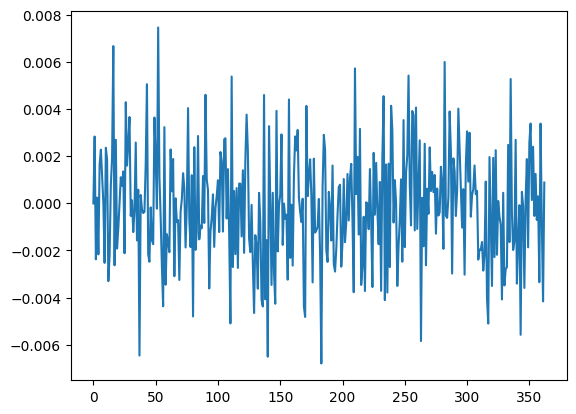

In [5]:
plt.plot(Y_data)

## To manually create confidence intervals, we sample multiple Y vals

In [8]:
N_sample = 100

sample_holder = np.zeros((N, N_sample))

for j in range(n_dependence, N):
    
    r_hist = r_mat[j - 1]
    f_dep = f_mat[j-n_dependence : j]
    
    samples = np.zeros(N_sample)
    
    for jj in range(N_sample):
        new_factor = risk_factor_generator(
            f_dep, 
            AR_effect_F,
            noise_diagLambda_F,
            FE_Args(weights = wei),
            NOI_Args(eig_vals = eig_Lambda)
        )
        
        new_q = q_generator(
            new_factor,
            Gamma,
            noise_iid_F,
            NOI_Args(sigma = sig_eps)
        )
        
        new_r = np.clip(r_hist + new_q, a_min = 0, a_max = 1)
        new_b = Bond_PortVal(new_r, S_mature, positions)
    
        samples[jj] = new_b - b_val[j-1]
    
    
    sample_holder[j] = samples